In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
airbnb = pd.read_csv("data/20240614-London-listings.csv.gz")

airbnb = gpd.GeoDataFrame(airbnb, 
                       geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude), 
                       crs="EPSG:4326").to_crs(epsg=27700)


In [3]:
from datetime import datetime, timedelta


filtered_airbnb=airbnb[airbnb.minimum_nights<=30]

# Convert 'last_review' to datetime format
filtered_airbnb.loc[:, 'last_review'] = pd.to_datetime(filtered_airbnb['last_review'], errors='coerce')

# Set the reference date (for reproducibility)
reference_date = datetime(2024, 11, 28)

# Calculate the threshold date (6 months before the reference date)
six_months_ago = reference_date - timedelta(days=6 * 30) 

# Filter the data
filtered_airbnb = filtered_airbnb[filtered_airbnb['last_review'] >= six_months_ago]

filtered_airbnb = filtered_airbnb[filtered_airbnb['availability_365'] >= 90]

filtered_airbnb = filtered_airbnb[filtered_airbnb['room_type'] == "Entire home/apt"]

In [4]:
ward_profiles = pd.read_csv("data/ward-profiles.csv", encoding="latin1")

ward_profiles.head(5)

,Ward name,Old code,New code,Population - 2015,Children aged 0-15 - 2015,Working-age (16-64) - 2015,Older people aged 65+ - 2015,% All Children aged 0-15 - 2015,% All Working-age (16-64) - 2015,% All Older people aged 65+ - 2015,...,A-Level Average Point Score Per Student - 2013/14,A-Level Average Point Score Per Entry; 2013/14,Crime rate - 2014/15,Violence against the person rate - 2014/15,"Deliberate Fires per 1,000 population - 2014",% area that is open space - 2014,Cars per household - 2011,Average Public Transport Accessibility score - 2014,% travel by bicycle to work - 2011,Turnout at Mayoral election - 2012
0,City of London,00AA,E09000001,8100,650,6250,1250,8.0,76.9,15.2,...,662.9,210.5,656.4,85.3,0.4,18.6,0.4,7.9,5.3,48.5
1,Barking and Dagenham - Abbey,00ABFX,E05000026,14750,3850,10150,750,26.0,69.0,5.0,...,682.6,208.9,138.1,42.2,1.4,21.9,0.5,6.0,0.8,25.7
2,Barking and Dagenham - Alibon,00ABFY,E05000027,10600,2700,6800,1050,25.7,64.3,10.0,...,627.9,201.6,73.6,27.3,0.7,20.6,0.8,3.1,1.0,20.3
3,Barking and Dagenham - Becontree,00ABFZ,E05000028,12700,3200,8350,1100,25.4,65.9,8.7,...,632.0,207.9,79.9,27.6,1.2,1.9,0.9,2.9,1.6,22.5
4,Barking and Dagenham - Chadwell Heath,00ABGA,E05000029,10400,2550,6400,1450,24.3,61.5,14.2,...,613.9,210.5,76.1,24.6,1.3,56.0,0.9,2.3,1.2,25.3


In [5]:
wards = gpd.read_file("data/London-wards-2011/London_Ward_CityMerged.shp").to_crs(epsg=27700)[["GSS_CODE","HECTARES","geometry"]]

wards.head(5)

,GSS_CODE,HECTARES,geometry
0,E05000405,755.173,"POLYGON ((516401.6 160201.8, 516407.3 160210.5..."
1,E05000414,259.464,"POLYGON ((517829.6 165447.1, 517837.1 165469.4..."
2,E05000401,145.390,"POLYGON ((518107.5 167303.4, 518114.3 167307.5..."
3,E05000400,268.506,"POLYGON ((520480 166909.8, 520490.7 166901.9, ..."
4,E05000402,187.821,"POLYGON ((522071 168144.9, 522063.9 168144, 52..."


In [6]:
pubs = gpd.read_file("data/pubs.geojson").to_crs(epsg=27700)
pubs["geometry"] = pubs.geometry.centroid

pubs = pubs[["name","geometry"]]

pubs.head(5)

,name,geometry
0,The Queens,POINT (530228.555 188568.967)
1,The Gilpin's Bell,POINT (534047.067 191909.103)
2,The Ship and Shovell,POINT (530236.721 180413.513)
3,Crown and Sceptre,POINT (522498.283 179750.168)
4,Princess Victoria,POINT (522169.523 180067.4)


## merging

In [7]:
merged = wards.merge(ward_profiles, left_on = "GSS_CODE", right_on = "New code", how = "left")

merged = gpd.GeoDataFrame(merged, crs = "EPSG:27700")

merged.head(5)

,GSS_CODE,HECTARES,geometry,Ward name,Old code,New code,Population - 2015,Children aged 0-15 - 2015,Working-age (16-64) - 2015,Older people aged 65+ - 2015,...,A-Level Average Point Score Per Student - 2013/14,A-Level Average Point Score Per Entry; 2013/14,Crime rate - 2014/15,Violence against the person rate - 2014/15,"Deliberate Fires per 1,000 population - 2014",% area that is open space - 2014,Cars per household - 2011,Average Public Transport Accessibility score - 2014,% travel by bicycle to work - 2011,Turnout at Mayoral election - 2012
0,E05000405,755.173,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",Kingston upon Thames - Chessington South,00AXGC,E05000405,10550,2200,6800,1500,...,643.4,203.6,47.5,16.3,0.6,75.7,1.4,2.4,2.3,30.4
1,E05000414,259.464,"POLYGON ((517829.6 165447.1, 517837.1 165469.4...",Kingston upon Thames - Tolworth and Hook Rise,00AXGM,E05000414,10650,2150,7050,1450,...,714.3,213.3,53.7,14.2,0.7,33.1,1.2,2.3,2.9,32.1
2,E05000401,145.390,"POLYGON ((518107.5 167303.4, 518114.3 167307.5...",Kingston upon Thames - Berrylands,00AXFY,E05000401,9800,1800,6500,1500,...,733.7,212.9,31.6,8.2,0.3,10.9,1.0,2.8,4.6,38.0
3,E05000400,268.506,"POLYGON ((520480 166909.8, 520490.7 166901.9, ...",Kingston upon Thames - Alexandra,00AXFX,E05000400,9700,1900,6200,1600,...,762.2,215.2,34.7,7.9,0.3,43.7,1.4,2.2,3.9,36.3
4,E05000402,187.821,"POLYGON ((522071 168144.9, 522063.9 168144, 52...",Kingston upon Thames - Beverley,00AXFZ,E05000402,10450,2200,6900,1350,...,761.5,219.3,64.5,15.4,0.7,26.4,1.0,2.8,4.4,41.2


In [8]:
merged["n_pubs"] = merged.geometry.apply(lambda geom: sum(pubs.geometry.intersects(geom)))
merged["pub_density"] = merged["n_pubs"] / merged["HECTARES"]

merged["n_airbnb"] = merged.geometry.apply(lambda geom: sum(filtered_airbnb.geometry.intersects(geom)))
merged["airbnb_density"] = merged["n_airbnb"] / merged["HECTARES"]


<Axes: >

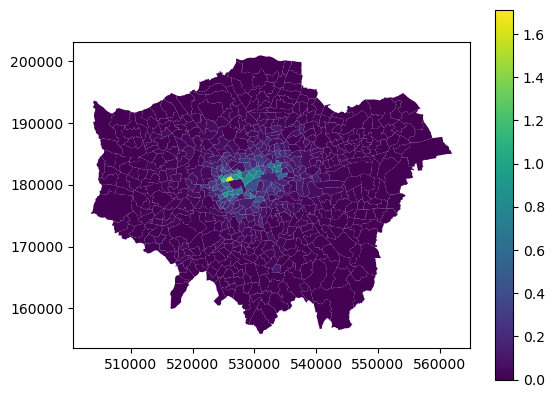

In [9]:
merged.plot(column = "airbnb_density", cmap="viridis", legend = True)

In [10]:
merged.sort_values(by='airbnb_density', ascending=False).head(5)

,GSS_CODE,HECTARES,geometry,Ward name,Old code,New code,Population - 2015,Children aged 0-15 - 2015,Working-age (16-64) - 2015,Older people aged 65+ - 2015,...,"Deliberate Fires per 1,000 population - 2014",% area that is open space - 2014,Cars per household - 2011,Average Public Transport Accessibility score - 2014,% travel by bicycle to work - 2011,Turnout at Mayoral election - 2012,n_pubs,pub_density,n_airbnb,airbnb_density
479,E05000638,63.082,"POLYGON ((526231.9 181414.8, 526235.5 181411.1...",Westminster - Lancaster Gate,00BKGJ,E05000638,13800,1600,11050,1150,...,0.1,8.6,0.4,7.7,6.0,27.4,9,0.142671,108,1.712057
469,E05000394,48.904,"POLYGON ((524551.3 180815.2, 524554 180816.5, ...",Kensington and Chelsea - Pembridge,00AWGL,E05000394,7700,1100,5700,950,...,0.0,11.9,0.5,7.0,4.8,30.6,5,0.102241,57,1.165549
486,E05000632,72.318,"POLYGON ((527921.9 181967, 527966.7 181831.8, ...",Westminster - Bryanston and Dorset Square,00BKGC,E05000632,12650,1350,9950,1350,...,0.0,2.1,0.4,8.0,4.8,30.8,15,0.207417,74,1.023258
481,E05000636,95.514,"POLYGON ((527761.7 180969.8, 527714.9 180961.8...",Westminster - Hyde Park,00BKGG,E05000636,13450,1750,10400,1300,...,0.1,8.9,0.5,8.0,4.6,29.1,15,0.157045,89,0.931801
473,E05000388,45.828,"POLYGON ((524933.5 178522.2, 524954 178535.6, ...",Kensington and Chelsea - Earl's Court,00AWGE,E05000388,9300,1150,7300,900,...,0.2,10.0,0.4,7.0,3.8,27.9,6,0.130924,41,0.894650
